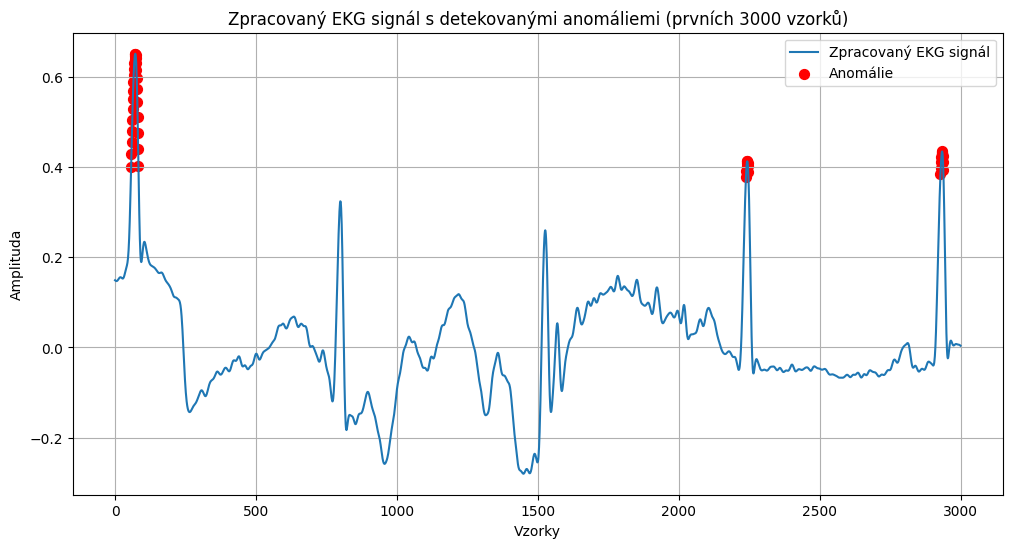

In [1]:
import wfdb
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

# Hlavní adresář se složkami EKG měření
main_directory = "bpm/"

# Funkce pro detekci anomálií
def detect_anomalies(signal, threshold=3):
    anomalies = []
    mean = np.mean(signal)
    std = np.std(signal)
    for i in range(len(signal)):
        if abs(signal[i] - mean) > threshold * std:
            anomalies.append(i)
    return anomalies

# Funkce pro pásmovou filtrační metodu
def bandpass_filter(signal, lowcut, highcut, fs, order):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# Pro jednu konkrétní složku detekujeme anomálie
ekg_directory = os.path.join(main_directory, "100002")

# Načtení všech dostupných souborů ve složce
files = os.listdir(ekg_directory)
signal_basenames = set(f.split(".")[0] for f in files if f.endswith("ECG.dat"))

if len(signal_basenames) > 0:
    signal_basename = list(signal_basenames)[0]
    record_path = os.path.join(ekg_directory, signal_basename)

    # Načtení signálu
    record = wfdb.rdsamp(record_path)
    signal = record[0][:, 0]  # První kanál
    fields = record[1]

    # Parametry
    sampling_frequency = fields["fs"]  # Vzorkovací frekvence (Hz)
    lowcut = 0.5  # Dolní hranice pásmové filtrace (Hz)
    highcut = 50.0  # Horní hranice pásmové filtrace (Hz)
    filter_order = 4  # Pořadí filtru

    # Pouze prvních 3000 vzorků
    signal = signal[3000:6000]

    # Normalizace signálu
    signal_normalized = (signal - np.mean(signal)) / np.std(signal)

    # Aplikace filtrace
    try:
        signal_processed = bandpass_filter(signal_normalized, lowcut, highcut, sampling_frequency, filter_order)
    except ValueError as e:
        print(f"Chyba filtrace: {e}")
        signal_processed = signal_normalized

    # Detekce anomálií
    anomalies = detect_anomalies(signal_processed)

    # Vykreslení celého signálu s označenými anomáliemi
    plt.figure(figsize=(12, 6))
    plt.plot(signal_processed, label="Zpracovaný EKG signál")
    plt.scatter(anomalies, signal_processed[anomalies], color="red", label="Anomálie", s=50)
    plt.title("Zpracovaný EKG signál s detekovanými anomáliemi (prvních 3000 vzorků)")
    plt.xlabel("Vzorky")
    plt.ylabel("Amplituda")
    plt.legend()
    plt.grid()
    plt.show()

    # # Vykreslení jednotlivých anomálních úseků
    # for anomaly in anomalies:
    #     start = max(0, anomaly - 100)
    #     end = min(len(signal_processed), anomaly + 100)
    #     plt.figure(figsize=(10, 4))
    #     plt.plot(range(start, end), signal_processed[start:end], label="Anomální úsek")
    #     plt.axvline(x=anomaly, color="red", linestyle="--", label="Anomálie")
    #     plt.title("Detail anomálního úseku")
    #     plt.xlabel("Vzorky")
    #     plt.ylabel("Amplituda")
    #     plt.legend()
    #     plt.grid()
    #     plt.show()